<a href="https://colab.research.google.com/github/frh02/CAN_Research/blob/main/GAN_CAN_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Load libraries and check memory

import psutil ; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[13653573632, 12823298048]
[13653573632, 12801191936]


In [3]:

# Load custom functions

import GAN_171103

# For reloading after making changes
import importlib
importlib.reload(GAN_171103) 
from GAN_171103 import *


In [4]:

# Load engineered dataset from EDA section
#data = pickle.load(open('/content/creditcard.csv')
#data = pickle.load(open('data/' + 'credicard.engineered.pkl','rb'))
data = pd.read_csv('/content/can_data.csv')
# data columns will be all other columns except class
properties = list(data.columns.values)
properties.remove('Time')
#properties_ben.remove('seconds')
properties.remove('ID')
properties.remove('DLC')
properties.remove('App')
properties.remove('Unnamed: 0')
properties.remove('Unnamed: 0.1')
#properties.remove('Target')
#data['Time']=data['Time'].apply(lambda x:  int(str(x),16))
#data['DLC']=data['DLC'].apply(lambda x:  int(str(x),16))
#data['Time']=data['Time'].apply(lambda x:  int(str(x),16))
data['D1']=data['D1'].apply(lambda x:  int(str(x),16))
data['D2']=data['D2'].apply(lambda x:  int(str(x),16))
data['D3']=data['D3'].apply(lambda x:  int(str(x),16))
data['D4']=data['D4'].apply(lambda x:  int(str(x),16))
data['D5']=data['D5'].apply(lambda x:  int(str(x),16))
data['D6']=data['D6'].apply(lambda x:  int(str(x),16))
data['D7']=data['D7'].apply(lambda x:  int(str(x),16))
data['D8']=data['D8'].apply(lambda x:  int(str(x),16))
x_dat= data[properties]
print(x_dat)

        seconds  Value  N   D1   D2   D3   D4   D5  D6  D7   D8  Target
0      0.000000    790  8    5   32  234   10   32  26   0  127       0
1      0.000224    809  8  215  167  127  140   17  47   0   16       0
2      0.000462    128  8    0   23  234   10   32  26  32   67       0
3      0.000704    129  8  127  132   96    0    0   0   0   83       0
4      0.000878    288  4    0    0    0    0   -1  -1  -1   -1       0
...         ...    ... ..  ...  ...  ...  ...  ...  ..  ..  ...     ...
89995  7.114431    848  8    5   32   52   95  134   0   0  200       1
89996  7.114927    880  8  255   32    0  128  255   0   0  236       1
89997  7.115429    898  8   64  254   15    0    0   0   0    4       1
89998  7.116169      0  8    0    0    0    0    0   0   0    0       1
89999  7.116921   1201  8    0    0    1    0    0   0   0    1       1

[90000 rows x 12 columns]


In [7]:

data_cols = list(x_dat.columns[ x_dat.columns != 'Target' ])
label_cols = ['Target']

print(data_cols)
print('# of data columns: ',len(data_cols))
print(x_dat)

['seconds', 'Value', 'N', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8']
# of data columns:  11
        seconds  Value  N   D1   D2   D3   D4   D5  D6  D7   D8  Target
0      0.000000    790  8    5   32  234   10   32  26   0  127       0
1      0.000224    809  8  215  167  127  140   17  47   0   16       0
2      0.000462    128  8    0   23  234   10   32  26  32   67       0
3      0.000704    129  8  127  132   96    0    0   0   0   83       0
4      0.000878    288  4    0    0    0    0   -1  -1  -1   -1       0
...         ...    ... ..  ...  ...  ...  ...  ...  ..  ..  ...     ...
89995  7.114431    848  8    5   32   52   95  134   0   0  200       1
89996  7.114927    880  8  255   32    0  128  255   0   0  236       1
89997  7.115429    898  8   64  254   15    0    0   0   0    4       1
89998  7.116169      0  8    0    0    0    0    0   0   0    0       1
89999  7.116921   1201  8    0    0    1    0    0   0   0    1       1

[90000 rows x 12 columns]


In [8]:
import sklearn.cluster as cluster

train = x_dat.loc[ x_dat['Target']==1 ].copy()

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Target'] = labels


   count
0  13757
1   6243


In [9]:
x_dat.groupby('Target')['Target'].count()

Target
0    70000
1    20000
Name: Target, dtype: int64

In [10]:
data.isnull().sum().sum()

0

In [11]:

normal_duplicates = sum( x_dat.loc[ data['Target']==0 ].duplicated() )
fraud_duplicates = sum( x_dat.loc[ data['Target']==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )

Normal duplicates 30
Fraud duplicates 0
Total duplicates 30
Fraction duplicated 0.0003333333333333333


In [12]:
x_dat.skew()

seconds    0.191814
Value      0.172706
N         -3.717094
D1         1.271078
D2         1.549968
D3         1.222073
D4         1.457263
D5         1.502761
D6         2.112764
D7         2.283987
D8         1.588159
Target     1.336328
dtype: float64

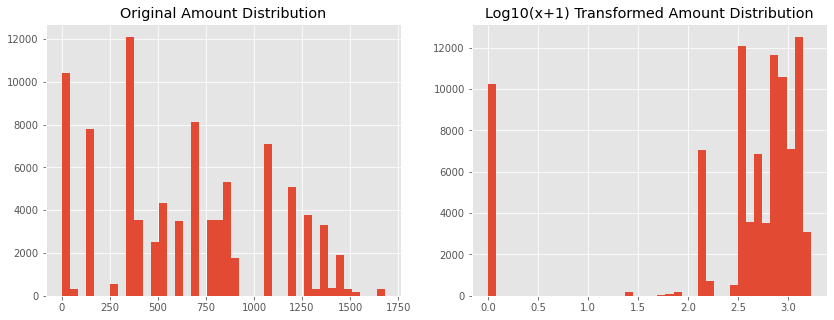

In [13]:

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(x_dat['Value'], bins=40)
plt.title('Original Amount Distribution')

plt.subplot(1,2,2)
d0 = np.log10( x_dat['Value'].values + 1 )
# d0 = np.log1p( data['Amount'].values ) / np.log(10)
plt.hist( d0, bins=40 )
plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()

In [14]:

x_dat['Value'] = d0

In [15]:
percentiles =  pd.DataFrame( np.array([ np.percentile( x_dat[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

percentile_means = \
    [ [ np.mean( x_dat.loc[ (x_dat[i]>percentiles[i]['min']) & (x_dat[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( x_dat.loc[ (x_dat[i]>percentiles[i]['min']) & (x_dat[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles


,seconds,Value,N,D1,D2,D3,D4,D5,D6,D7,D8
min,0.005373,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,9.986479,3.225568,8.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,224.000000,254.000000
mean,4.534898,2.776109,4.600591,43.601145,49.865858,53.041426,33.250493,29.929416,28.212767,29.036169,44.654545
stdev,2.821667,0.303875,0.764739,75.063519,70.497826,71.089092,55.028331,57.090598,50.126000,54.186185,69.393324


In [16]:
x_dat[data_cols] = ( x_dat[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]


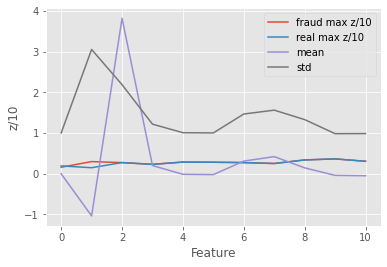

In [18]:

plot_cols = data_cols
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( x_dat.loc[ x_dat.Target==1, plot_cols ].abs().max().values / x_dat[ plot_cols ].std().values / 10, label='fraud max z/10' )
plt.plot( x_dat.loc[ x_dat.Target==0, plot_cols ].abs().max().values / x_dat[ plot_cols ].std().values / 10, label='real max z/10' )
plt.plot( x_dat[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( x_dat[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ; 

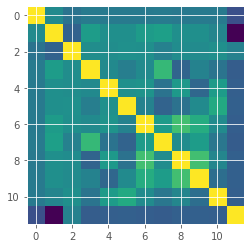

In [19]:
corr0 = x_dat.corr()
plt.imshow(corr0) ;

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

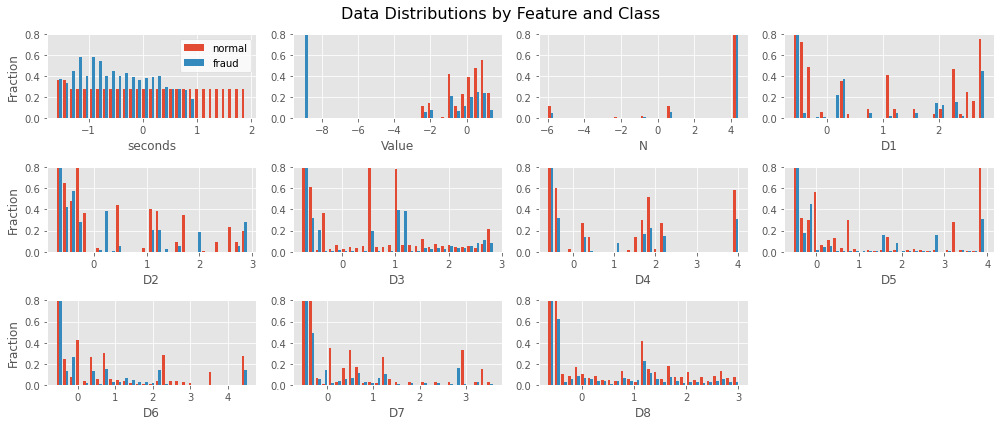

In [20]:

# Plot the data by each feature

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ x_dat.loc[ x_dat.Target == 0, col ], x_dat.loc[ x_dat.Target == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(x_dat[col],0.1), np.percentile(x_dat[col],99.9), 30 ),
                          density=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')
plt.show()

In [21]:
# define the columns we want to test on, in case we want to use less than the full set

test_cols = x_dat.columns

# test_cols = data.columns[ data.columns != 'Amount' ]

print(len(test_cols))
print(test_cols)

12
Index(['seconds', 'Value', 'N', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'Target'],
      dtype='object')


In [22]:
# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)


In [23]:
# Set up the test and train sets

np.random.seed(0)

n_real = np.sum(x_dat.Target==0) # 200000
n_test = np.sum(x_dat.Target==1) # 492
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = x_dat.loc[ x_dat.Target==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = x_dat.loc[ x_dat.Target==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

classes 0, 1:  70000 20000
train, test:  63000 27000


In [24]:

# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['Target'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

best iteration:  81
('recall', 0.8348333333333333)
('precision', 0.9922741679873217)
('roc_auc', 0.9836782777777777)
Confusion Matrix


,Pred 0,Pred 1
True 0,20961,39
True 1,991,5009


Accuracy : 0.9618518518518518


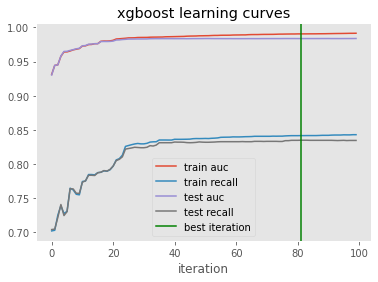

In [25]:
# Let's look at how the metrics changed on the train and test sets as more trees were added

for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

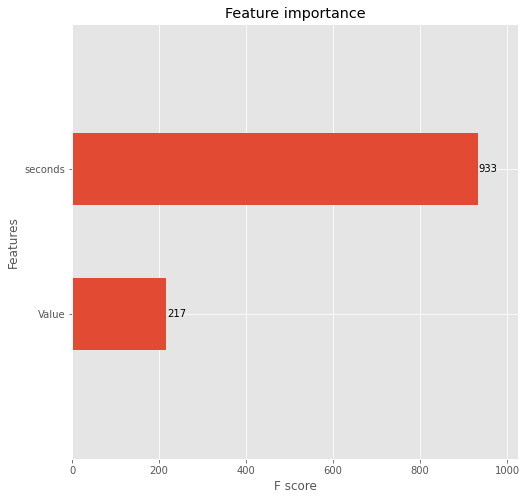

In [26]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=2, height=0.5, ax=ax);

In [27]:
import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

# print( 'Top eight features for fraud detection: ', [ i[0] for i in sorted_x[:8] ] )

sorted_cols = [i[0] for i in sorted_x] + ['Target']
print( sorted_cols )


['seconds', 'Value', 'D1', 'D2', 'D3', 'D8', 'D6', 'D7', 'D5', 'D4', 'N', 'Target']


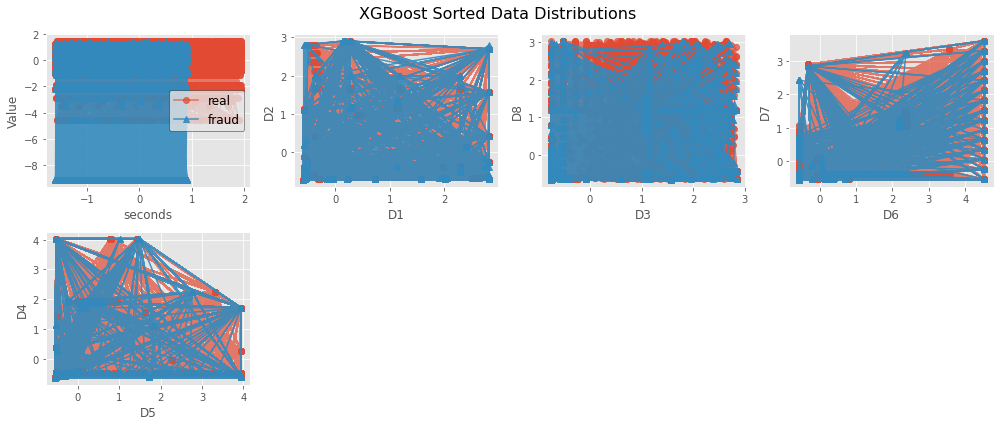

In [28]:
# Plot all of the training data with paired features sorted by importance
# This takes a while

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3.5, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/2)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
#     print(i,col1,col2)
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('Target'), colors, markers, labels, alphas ):
        #plt.scatter( group[1][col1], group[1][col2], 
        #                 label=label, marker=marker, alpha=alpha,
        #                 edgecolors=color, facecolors='none' ) 
        plt.plot( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha)         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/XGB_Sorted_Data_Distributions.png')
plt.show()

In [29]:
# Lets look at the effect of the ratio of normal:fraud data in the dataset on recall and roc_auc
# We'll use cross validation to see if differences are significant


np.random.seed(0)

n_real = np.sum(x_dat.Target==0) # 200000
n_test = np.sum(x_dat.Target==1) # 492
real_samples = x_dat.loc[ x_dat.Target==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = x_dat.loc[ x_dat.Target==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)
X_col = x_dat.columns[:-1]
y_col = x_dat.columns[-1]

test_data=[]

# for i in [1]:
# for i in [0.1,0.5,1,2,10]:
for i in np.logspace(-1,2,8):
    print(i)
    train_df = pd.concat([real_samples[:int(n_test*i)],test_samples[:n_test]],axis=0,ignore_index=True).reset_index(drop=True)
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    results = xgb.cv(xgb_params, dtrain, 
                     nfold=5, num_boost_round=100, early_stopping_rounds=10, seed=0,
                     feval=recall)
    test_data.append(list([i]) + list(results.tail(1).index) + list(results.tail(1).values[0]))
    
test_data = pd.DataFrame(test_data, columns=list(['ratio','best'])+list(results.columns))
test_data

0.1
0.2682695795279726
0.7196856730011519
1.9306977288832496
5.17947467923121
13.894954943731374
37.27593720314938
100.0


,ratio,best,train-auc-mean,train-auc-std,train-recall-mean,train-recall-std,test-auc-mean,test-auc-std,test-recall-mean,test-recall-std
0,0.100000,3,0.964499,0.000883,0.998249,0.001083,0.963340,0.002972,0.998353,0.001118
1,0.268270,2,0.960895,0.000706,0.995861,0.001642,0.960192,0.001588,0.995311,0.001621
2,0.719686,0,0.944889,0.000438,0.755813,0.003363,0.944480,0.001651,0.755129,0.004179
3,1.930698,0,0.941355,0.003692,0.740672,0.010359,0.941341,0.005661,0.740824,0.017873
4,5.179475,0,0.930832,0.000260,0.702111,0.001161,0.930831,0.001410,0.702725,0.004792
5,13.894955,0,0.930832,0.000260,0.702111,0.001161,0.930831,0.001410,0.702725,0.004792
6,37.275937,0,0.930832,0.000260,0.702111,0.001161,0.930831,0.001410,0.702725,0.004792
7,100.000000,0,0.930832,0.000260,0.702111,0.001161,0.930831,0.001410,0.702725,0.004792


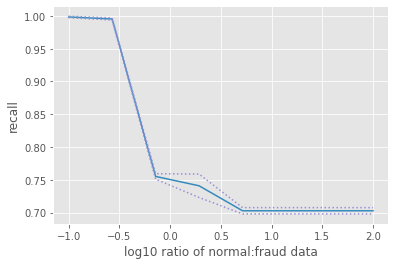

In [31]:

# Recall decreases as more normal data is added

# metric = 'auc'
metric = 'recall'
# xs = test_data['ratio'].values
xs = np.log10(test_data['ratio'].values)
ys = test_data['test-'+metric+'-mean'].values
stds = test_data['test-'+metric+'-std'].values
plt.plot(xs,ys,c='C1')
plt.plot(xs,ys+stds,linestyle=':',c='C2')
plt.plot(xs,ys-stds,linestyle=':',c='C2')
plt.xlabel('log10 ratio of normal:fraud data')
plt.ylabel(metric)
# plt.ylim([0.96,1.01])
plt.show()

In [32]:
import sklearn.cluster as cluster


In [33]:

# hdbscan not in kaggle/python at present

!pip install hdbscan
import hdbscan

     |████████████████████████████████| 6.4MB 5.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311640 sha256=4d6c017728465db5d7389e16c2dda87a681b1409e0e17aacfffed3c0a258b4f3
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan


In [43]:

train = x_dat.loc[ x_dat['Target']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['Target']==i)] for i in np.unique(train['Target']) ], columns=['count'], index=np.unique(train['Target']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Target' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]


   count
1  20000


In [34]:
# Set up training set to consist of only fraud data

train = x_dat.loc[ x_dat['Target']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['Target']==i)] for i in np.unique(train['Target']) ], columns=['count'], index=np.unique(train['Target']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Target' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]
print(data_cols[1])


   count
1  20000
Value


In [45]:
#%%time

# TSNE is an interesting method to map higher dimensional data into two dimensions
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Note TSNE map may not be what you might think:
# https://distill.pub/2016/misread-tsne/

# Create multiple projections to compare results from different random states

from sklearn.manifold import TSNE

projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(3) ]

KeyboardInterrupt: ignored

0 KMeans


NameError: ignored

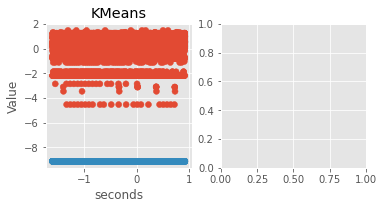

In [46]:
#%%time 

# Now we'll compare some different clustering algorithms
# https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/comparing_clustering_algorithms.rst

algorithms = [ 
#     [ 'KMeans', cluster.KMeans, (), {'random_state':0} ],
    [ 'KMeans', cluster.KMeans, (), {'n_clusters':2, 'random_state':0} ],
#     [ 'KMeans 3', cluster.KMeans, (), {'n_clusters':3, 'random_state':0} ],
#     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {} ],
    [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
#     [ 'Agg. Ave 3', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 3} ],
#     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 3} ],
#     [ 'DBSCAN', cluster.DBSCAN, (), {'eps':0.025} ],
#     [ 'HDBSCAN', hdbscan.HDBSCAN, (), {} ],
    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],
#     [ 'HDBSCAN 2 10', hdbscan.HDBSCAN, (), {'min_cluster_size':2, 'min_samples':10, } ],
#     [ 'HDBSCAN 10 10 ', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':10, } ],
]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)
#     labels = algorithm(*args, **kwds).fit_predict(projections[0])
    
#     print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )
    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)
        
#     break

plt.suptitle('Comparison of Fraud Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('plots/Fraud_Cluster_Diagram.png')
plt.show()

In [47]:
# Now pick a set of labels and add to the dataset

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)
# labels = algorithm(*args, **kwds).fit_predict(projections[0])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Target'] = labels


   count
0   9750
1  10250


In [48]:

# Let's see which features are most useful for detecting differences between the classes:

dtrain = xgb.DMatrix(fraud_w_classes[data_cols], fraud_w_classes['Target'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
    }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )


Top eight features:  [['Value', 10]]


In [53]:

# reloading the libraries and setting the parameters


import GAN_171103
import importlib
importlib.reload(GAN_171103) # For reloading after making changes
from GAN_171103 import *

rand_dim = 32 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = '/content/cache'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Target' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim:  11
data_cols:  ['seconds', 'Value', 'N', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8']
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dense_80 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_81 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_82 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_83 (Dense)             (None, 11)                5643      
Total params: 174,475
Trainable params: 174,475
Non-trainable params: 0
_________________________________________________________________
None
Model: "disc

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 0 of 501.
Losses: G, D Gen, D Real, Xgb: 0.6874, 0.7163, 0.6842, 0.9919
D Real - D Gen: -0.0321
      seconds     Value         N  ...        D6        D7        D8
0    0.075792 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
1   -0.102007 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
2    0.031682  0.125892 -0.601590  ... -0.058279 -0.055431 -0.065791
3    0.075510  0.043563  0.444519  ...  0.031495 -0.053586 -0.041293
4   -0.098864 -0.285520 -0.078535  ... -0.058279 -0.055431 -0.065791
..        ...       ...       ...  ...       ...       ...       ...
487  0.082894 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
488 -0.088394 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
489 -0.070962  0.017081  0.444519  ... -0.032344  0.284139 -0.061468
490  0.027727 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
491 -0.140552  0.099974  0.444519  ... -0.056284 -0.053586 -0.062909

[492 rows x 11 columns]
      seconds     Value         N  ...       

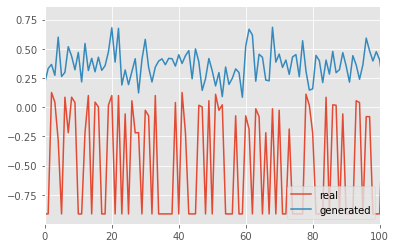

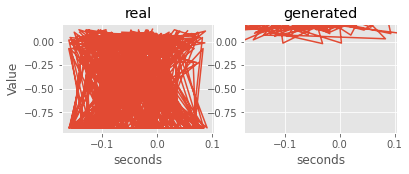

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9020, 0.6269, 0.7309, 0.9939
D Real - D Gen: 0.1040
      seconds     Value         N  ...        D6        D7        D8
0   -0.123787 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
1    0.022751 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
2   -0.058654 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
3    0.091273 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
4   -0.002362  0.116569  0.444519  ... -0.056284  0.031307 -0.064350
..        ...       ...       ...  ...       ...       ...       ...
487 -0.081247  0.017081  0.444519  ... -0.032344  0.284139 -0.061468
488  0.032632  0.040170  0.444519  ... -0.022369 -0.053586  0.118665
489  0.075545  0.085732  0.444519  ...  0.119274 -0.036977 -0.064350
490 -0.080793 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
491  0.013025 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350

[492 rows x 11 columns]
      seconds     Value         N  ...      

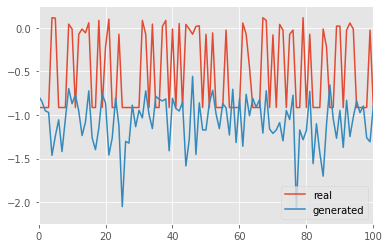

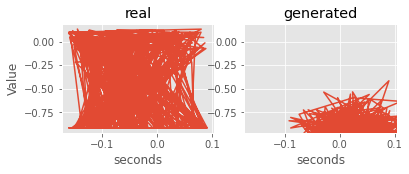

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2425, 0.4058, 0.6491, 0.9939
D Real - D Gen: 0.2433
      seconds     Value         N  ...        D6        D7        D8
0    0.078001 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
1    0.088957 -0.187341  0.444519  ...  0.013540 -0.053586 -0.061468
2   -0.011664 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
3   -0.064455 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
4   -0.035410 -0.111871  0.444519  ... -0.056284 -0.053586 -0.064350
..        ...       ...       ...  ...       ...       ...       ...
487 -0.064516 -0.025958  0.444519  ... -0.056284 -0.053586 -0.064350
488 -0.067756 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
489 -0.029483 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
490 -0.070422  0.085732  0.444519  ...  0.191093 -0.036977 -0.064350
491 -0.119874 -0.186456  0.444519  ... -0.056284 -0.053586 -0.064350

[492 rows x 11 columns]
      seconds     Value         N  ...      

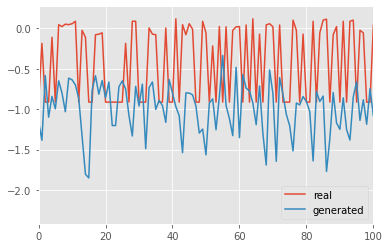

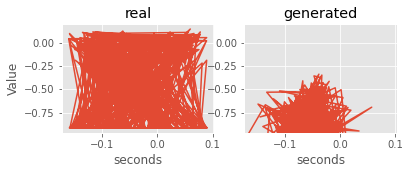

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 1.4581, 0.4064, 0.3367, 0.9959
D Real - D Gen: -0.0696
      seconds     Value         N  ...        D6        D7        D8
0   -0.067809 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
1   -0.066833 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
2   -0.152350 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
3   -0.090592 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
4   -0.007629 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
..        ...       ...       ...  ...       ...       ...       ...
487 -0.065008 -0.219011  0.444519  ... -0.022369 -0.012985  0.294474
488 -0.009908 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
489 -0.096646 -0.073531  0.444519  ... -0.056284 -0.053586 -0.052821
490 -0.126985 -0.057277  0.444519  ...  0.069400 -0.053586 -0.064350
491 -0.076914  0.058462  0.444519  ... -0.056284 -0.053586 -0.058586

[492 rows x 11 columns]
      seconds     Value         N  ...     

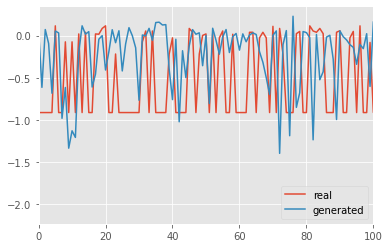

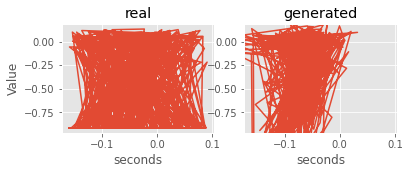

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 1.4960, 0.4069, 0.4671, 0.9980
D Real - D Gen: 0.0602
      seconds     Value         N  ...        D6        D7        D8
0   -0.157999 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
1   -0.037114 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
2   -0.072085 -0.217907  0.444519  ... -0.056284 -0.053586  0.219539
3   -0.124523 -0.073131  0.444519  ... -0.056284 -0.027749  0.128752
4   -0.055729 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
..        ...       ...       ...  ...       ...       ...       ...
487 -0.062131 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
488 -0.042906 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
489 -0.114433 -0.025958  0.444519  ... -0.056284 -0.053586 -0.064350
490 -0.087472  0.085864  0.444519  ...  0.103314 -0.036977 -0.064350
491 -0.047622 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350

[492 rows x 11 columns]
      seconds     Value         N  ...      

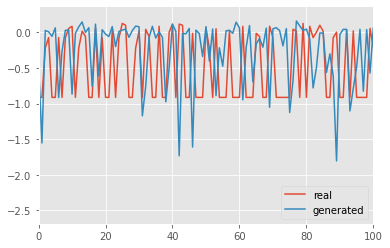

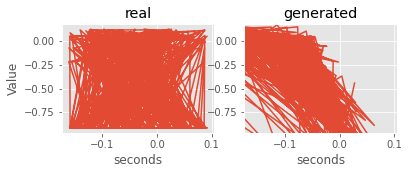

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.8235, 0.3613, 0.4700, 0.9959
D Real - D Gen: 0.1087
      seconds     Value         N  ...        D6        D7        D8
0   -0.091537 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
1   -0.031642 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
2   -0.115003 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
3    0.077080 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
4   -0.061557 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
..        ...       ...       ...  ...       ...       ...       ...
487 -0.096881 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
488 -0.081422 -0.080504  0.444519  ...  0.452434  0.182637 -0.044175
489 -0.056486 -0.217907  0.444519  ... -0.056284 -0.053586 -0.062909
490 -0.068242 -0.913570  0.444519  ... -0.056284 -0.053586 -0.064350
491 -0.142977 -0.219011  0.444519  ... -0.022369 -0.009294  0.231068

[492 rows x 11 columns]
      seconds     Value         N  ...      

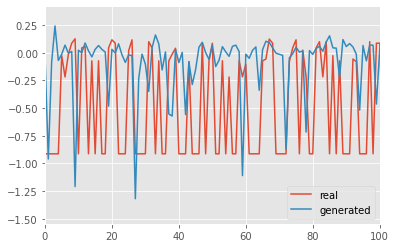

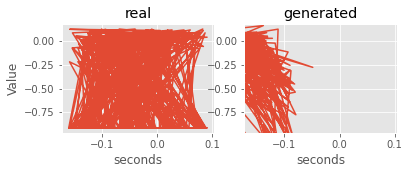

data_dim:  11
data_cols:  ['seconds', 'Value', 'N', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8']
label_dim:  1
label_cols:  ['Target']
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 33)           0           input_27[0][0]                   
                                                                 input_28[0][0]                   
___________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


_________________________________________________________________
dense_92 (Dense)             (None, 512)               6656      
_________________________________________________________________
dense_93 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_94 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 129       
Total params: 171,009
Trainable params: 0
Non-trainable params: 171,009
_________________________________________________________________
None
Model: "combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 32)]         0                                            
______________

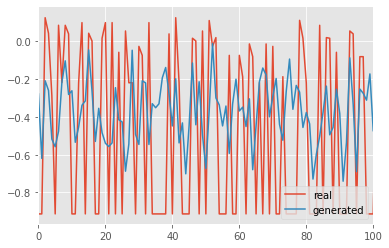

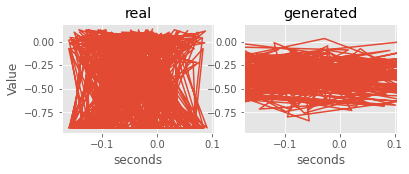

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0054, 0.5819, 0.5187, 0.9980
D Real - D Gen: -0.0632
      seconds     Value         N  ...        D7        D8  Target
0   -0.123787 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
1    0.022751 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
2   -0.058654 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
3    0.091273 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
4   -0.002362  0.116569  0.444519  ...  0.031307 -0.064350     0.0
..        ...       ...       ...  ...       ...       ...     ...
487 -0.081247  0.017081  0.444519  ...  0.284139 -0.061468     0.0
488  0.032632  0.040170  0.444519  ... -0.053586  0.118665     0.0
489  0.075545  0.085732  0.444519  ... -0.036977 -0.064350     0.0
490 -0.080793 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
491  0.013025 -0.913570  0.444519  ... -0.053586 -0.064350     1.0

[492 rows x 12 columns]
      seconds     Value         N  ...        D7        D8  Target


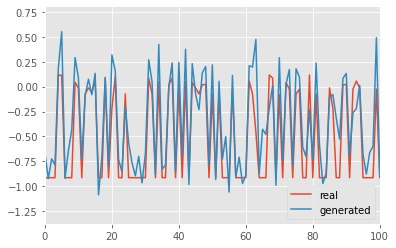

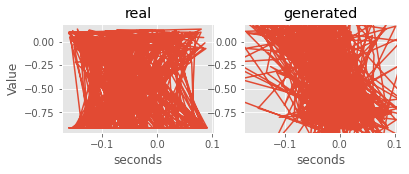

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 1.4074, 0.4991, 0.5263, 1.0000
D Real - D Gen: 0.0272
      seconds     Value         N  ...        D7        D8  Target
0    0.078001 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
1    0.088957 -0.187341  0.444519  ... -0.053586 -0.061468     0.0
2   -0.011664 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
3   -0.064455 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
4   -0.035410 -0.111871  0.444519  ... -0.053586 -0.064350     0.0
..        ...       ...       ...  ...       ...       ...     ...
487 -0.064516 -0.025958  0.444519  ... -0.053586 -0.064350     0.0
488 -0.067756 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
489 -0.029483 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
490 -0.070422  0.085732  0.444519  ... -0.036977 -0.064350     0.0
491 -0.119874 -0.186456  0.444519  ... -0.053586 -0.064350     0.0

[492 rows x 12 columns]
      seconds     Value         N  ...        D7        D8  Target
0

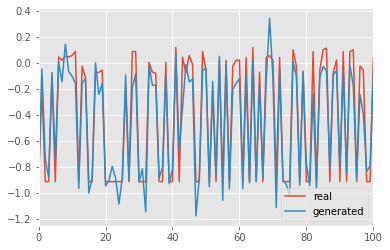

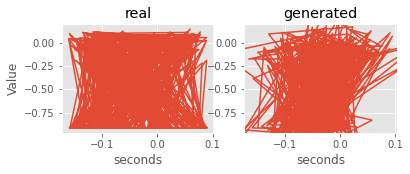

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 1.6602, 0.5225, 0.3463, 1.0000
D Real - D Gen: -0.1762
      seconds     Value         N  ...        D7        D8  Target
0   -0.067809 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
1   -0.066833 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
2   -0.152350 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
3   -0.090592 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
4   -0.007629 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
..        ...       ...       ...  ...       ...       ...     ...
487 -0.065008 -0.219011  0.444519  ... -0.012985  0.294474     0.0
488 -0.009908 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
489 -0.096646 -0.073531  0.444519  ... -0.053586 -0.052821     0.0
490 -0.126985 -0.057277  0.444519  ... -0.053586 -0.064350     0.0
491 -0.076914  0.058462  0.444519  ... -0.053586 -0.058586     0.0

[492 rows x 12 columns]
      seconds     Value         N  ...        D7        D8  Target


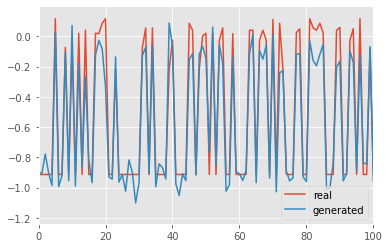

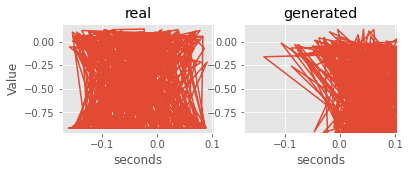

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 2.1303, 0.3469, 0.3525, 1.0000
D Real - D Gen: 0.0055
      seconds     Value         N  ...        D7        D8  Target
0   -0.157999 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
1   -0.037114 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
2   -0.072085 -0.217907  0.444519  ... -0.053586  0.219539     0.0
3   -0.124523 -0.073131  0.444519  ... -0.027749  0.128752     0.0
4   -0.055729 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
..        ...       ...       ...  ...       ...       ...     ...
487 -0.062131 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
488 -0.042906 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
489 -0.114433 -0.025958  0.444519  ... -0.053586 -0.064350     0.0
490 -0.087472  0.085864  0.444519  ... -0.036977 -0.064350     0.0
491 -0.047622 -0.913570  0.444519  ... -0.053586 -0.064350     1.0

[492 rows x 12 columns]
      seconds     Value         N  ...        D7        D8  Target
0

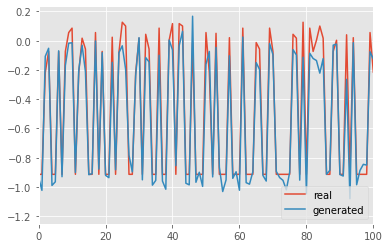

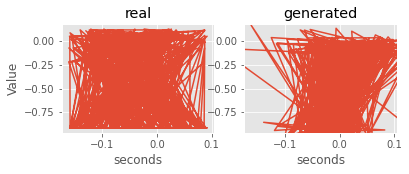

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 2.3912, 0.3449, 0.4137, 1.0000
D Real - D Gen: 0.0688
      seconds     Value         N  ...        D7        D8  Target
0   -0.091537 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
1   -0.031642 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
2   -0.115003 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
3    0.077080 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
4   -0.061557 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
..        ...       ...       ...  ...       ...       ...     ...
487 -0.096881 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
488 -0.081422 -0.080504  0.444519  ...  0.182637 -0.044175     0.0
489 -0.056486 -0.217907  0.444519  ... -0.053586 -0.062909     0.0
490 -0.068242 -0.913570  0.444519  ... -0.053586 -0.064350     1.0
491 -0.142977 -0.219011  0.444519  ... -0.009294  0.231068     0.0

[492 rows x 12 columns]
      seconds     Value         N  ...        D7        D8  Target
0

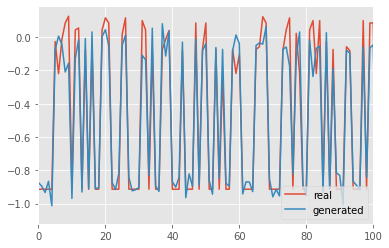

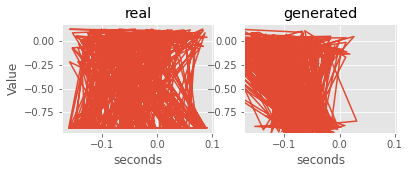

CPU times: user 2min 20s, sys: 4.69 s, total: 2min 24s
Wall time: 2min 7s


In [54]:
%%time

# Training the vanilla GAN and CGAN architectures

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN